In [314]:
%pip install xgboost
%pip install lightgbm
%pip install catboost
%pip install optuna
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [391]:
import json
from typing import Dict, List, Sequence, Tuple, Optional
from warnings import simplefilter

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, precision_recall_curve, 
                             ConfusionMatrixDisplay, f1_score, log_loss, 
                             precision_score, recall_score, roc_auc_score, 
                             roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

simplefilter(action='ignore', category=FutureWarning)


In [334]:
def preprocess_bank_data(file_path: str)-> tuple([pd.DataFrame, List[str]]):
    """
    Preprocesses the bank dataset by encoding categorical variables and updating 
    the target variable.

    Args:
        file_path (str): Path to the CSV file containing the bank dataset.

    Returns:
        pd.DataFrame: A DataFrame with encoded categorical features and binary target.
        list: A list of column names that were identified as categorical and encoded.
    """

    bank_df = pd.read_csv(file_path, sep=';')

    bank_df['y'] = bank_df['y'].map({'yes': 1, 'no': 0})

    categorical_columns = bank_df.select_dtypes(include=['object']).columns
    categorical_columns = categorical_columns[categorical_columns != 'y']


    bank_df[categorical_columns] = bank_df[categorical_columns].apply(lambda x: x.astype('category'))
    encoded_df = pd.get_dummies(bank_df, columns=categorical_columns, drop_first=True)

    return bank_df, encoded_df, categorical_columns

file_path = 'data/bank-direct-marketing.csv'
bank_df, processed_bank_df, categorical_columns = preprocess_bank_data(file_path)

First lets process the bank data to get it into a format that the algorithms can handle. As the data has a low cardinality I have chosen to use one hot encoding as this will retain the most information. The above function is used for all but the gradient boosting models for preprocessing.

In [85]:
def split_data(dataframe: pd.DataFrame, target_column_name: str,  
               test_size: float = 0.2)-> tuple(pd.DataFrame,pd.DataFrame,pd.Series, pd.Series):
    """
    Splits the provided DataFrame into training and testing sets.

    This function separates the features and the target variable, then uses 
    sklearn's train_test_split method to divide the dataset into training and 
    testing sets based on the specified test size. The split is stratified based 
    on the target variable.

    Args:
        dataframe (pd.DataFrame): The DataFrame to be split.
        target_column_name (str): The name of the target column.
        test_size (float, optional): The proportion of the dataset to include 
            in the test split. Defaults to 0.2.

    Returns:
        tuple: A tuple containing four elements (X_train, X_test, y_train, y_test),
               where 'X' denotes the features and 'y' denotes the target variable.
    """
    features = dataframe.drop(target_column_name, axis=1)
    target = dataframe[target_column_name]
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, stratify=target
    )

    return X_train, X_test, y_train, y_test



The above is simply splitting the data in the usual 80-20 split that I prefer when creating validation sets for my models, note the target is startisfied. The goal with this is to make the distribution of the train set match that of the validation set.

In [344]:
def eval_model(y_test: Sequence , predictions: Sequence, y_pred_proba:  Sequence)-> dict:
    """
    Evaluates a classification model's performance and plots ROC and confusion matrix.

    This function computes various performance metrics like AUC, F1 score, Precision,
    Recall, and Accuracy. It also generates a ROC curve and a confusion matrix plot.

    Args:
        y_test (array-like): True labels.
        predictions (array-like): Predicted labels.
        y_pred_proba (array-like): Predicted probabilities.

    Returns:
        dict: A dictionary containing the calculated performance metrics.
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrics = {
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'F1': f1_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions),
        'Recall': recall_score(y_test, predictions),
        'AUC Precision Recall' : auc(recall, precision),
        'Accuracy': accuracy_score(y_test, predictions)
    }


    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', 
            ylabel='True Positive Rate', title='Receiver Operating Characteristic')
    ax1.legend(loc="lower right")

    ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap=plt.cm.Blues, ax=ax2)
    ax2.set(title='Confusion Matrix')
    plt.tight_layout()

    return metrics


Above is the evaluation metrics choosen for this task, from the EDA we know that the data has a large class imbalance as such the accuracy score may not reflect the model preformance well, I have added several other metrics allowing the preformance on the minority class to be better measured. 

With the above functions defined we have all the pieces to build pipelines to evaluate a few different model options, the following will detail some of the models trialed, the reults and the final choice of model. Note that for the first few basic models I have tried to boost the preformance by doing hyperparmaeter tuning via grid search, this was possible as for many of these as they have few hyperparametes.

In [86]:
def train_and_predict_knn(X_train: np.ndarray, y_train: np.ndarray, 
                          X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray, GridSearchCV]:
    """
    Train a K-Nearest Neighbors classifier using GridSearchCV and predict on test data.

    This function trains a KNN classifier using a grid search to find the best number of 
    neighbors (from 1 to 20) based on cross-validation accuracy. It returns the predictions 
    on the test data, the probability estimates of the positive class, and the GridSearchCV 
    object for further inspection.

    Args:
      X_train (np.ndarray): Training data features.
      y_train (np.ndarray): Training data labels.
      X_test (np.ndarray): Test data features.

    Returns:
      Tuple[np.ndarray, np.ndarray, GridSearchCV]: A tuple containing the predicted labels 
        for the test data, probability estimates of the positive class for the test data, 
        and the trained GridSearchCV object.
    """

    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': list(range(1, 21))}
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_knn = grid_search.best_estimator_

    predictions = best_knn.predict(X_test)
    y_pred_probs = best_knn.predict_proba(X_test)[:, 1]

    return predictions, y_pred_probs, grid_search

An easy first model using KNN neighbours, KNN works by identifying the k closest data points (neighbors) to a query point and makes predictions based on these neighbors' majority vote. For more information on this model please see the docs here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html.

In [330]:
X_train, X_test, y_train, y_test = split_data(processed_bank_df, 'y')


{'AUC': 0.9208635283503939,
 'F1': 0.525664811379097,
 'Precision': 0.6168359941944848,
 'Recall': 0.4579741379310345,
 'Accuracy': 0.9068948773974266}

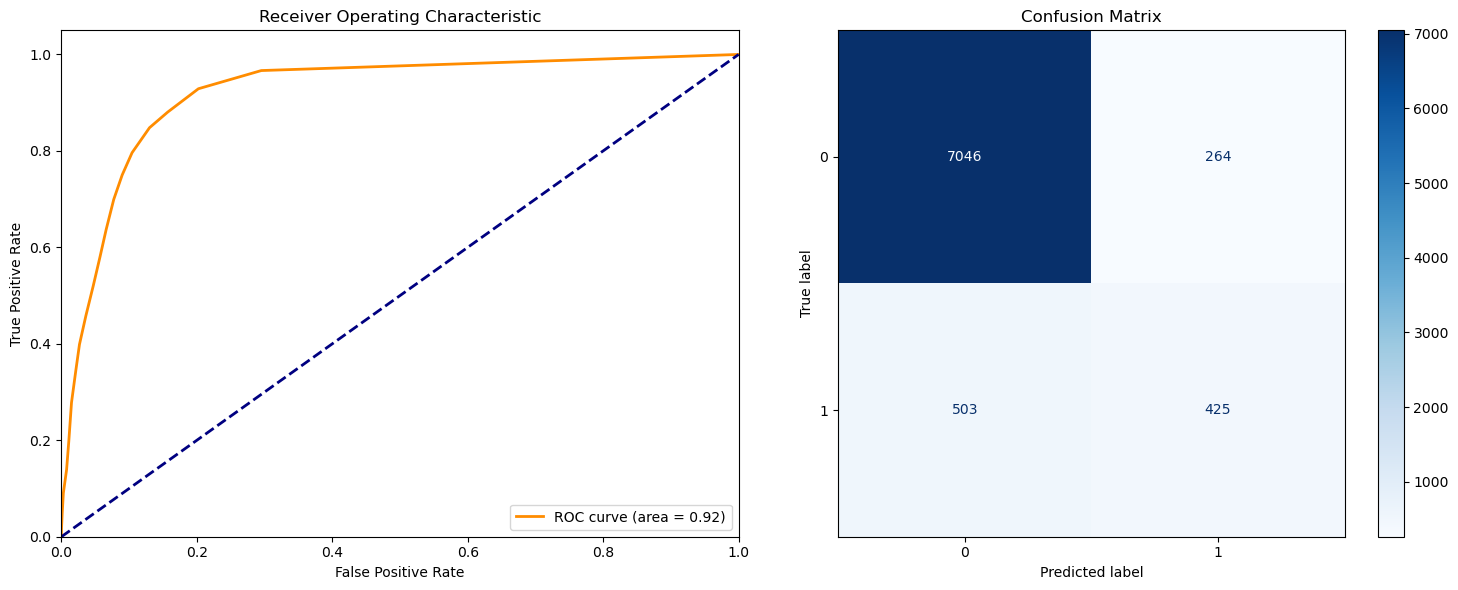

In [331]:
predictions_knn, y_pred_probs_knn, grid_search_knn = train_and_predict_knn(X_train, y_train, X_test)


{'AUC': 0.9208635283503939,
 'F1': 0.525664811379097,
 'Precision': 0.6168359941944848,
 'Recall': 0.4579741379310345,
 'AUC Precision Recall': 0.595500686984894,
 'Accuracy': 0.9068948773974266}

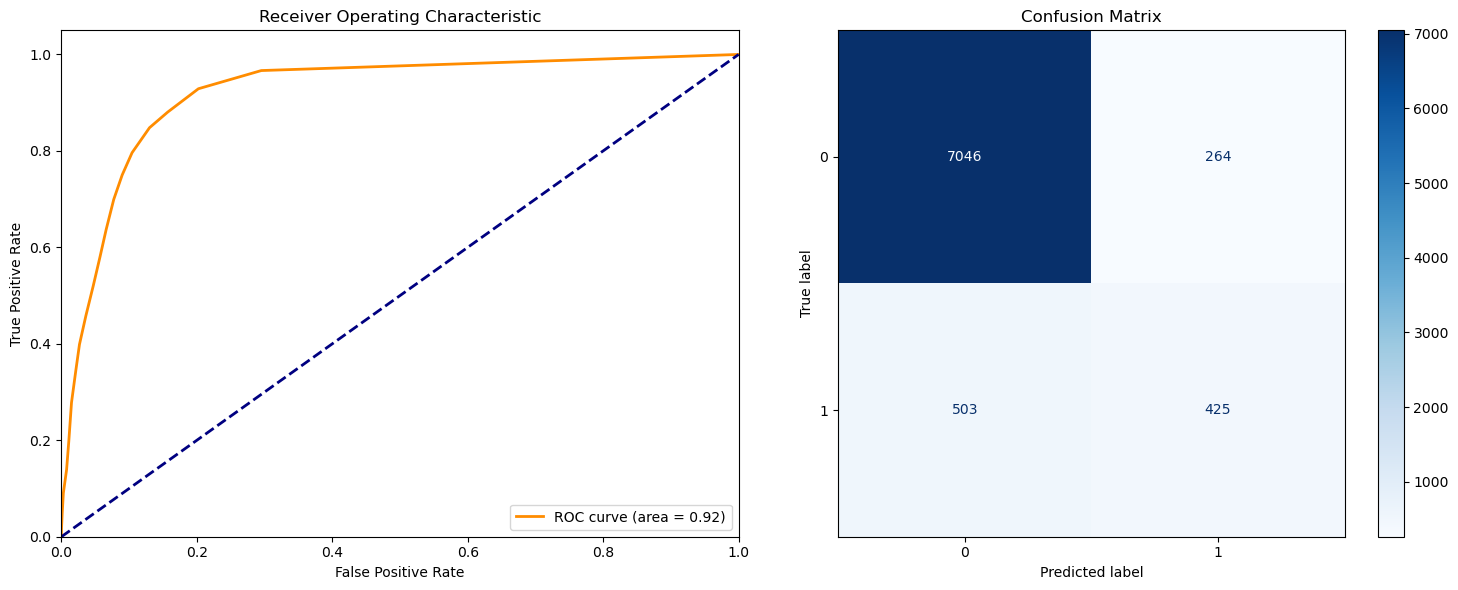

In [348]:
results_knn = eval_model(y_test, predictions_knn, y_pred_probs_knn)
results_knn

The next model trialed was the Niave Bayes algorithm, this is a probabilistic machine learning algorithm based on applying Bayes' theorem with the assumption of independence between every pair of features. For each class, it multiplies the probabilities of each feature belonging to that class and then normalizes these values to make a prediction. This is a known model used widely in the real world particularly for high dimensionality data such as text.

In [96]:
def train_and_predict_nb(X_train: np.ndarray, y_train: np.ndarray, 
                         X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray, GridSearchCV]:
    """
    Train a Naive Bayes classifier using GridSearchCV and predict on test data.

    This function trains a Gaussian Naive Bayes classifier using a grid search to find the best 
    'var_smoothing' parameter (selected from a range of 100 values between 1 and 10^-9) based on 
    cross-validation accuracy. It returns the predictions on the test data, the probability 
    estimates of the positive class, and the GridSearchCV object for further inspection.

    Parameters:
      X_train (np.ndarray): Training data features.
      y_train (np.ndarray): Training data labels.
      X_test (np.ndarray): Test data features.

    Returns:
      Tuple[np.ndarray, np.ndarray, GridSearchCV]: A tuple containing the predicted labels 
        for the test data, probability estimates of the positive class for the test data, 
        and the trained GridSearchCV object.
    """

    nb = GaussianNB()

    param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}

    grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_nb = grid_search.best_estimator_

    predictions = best_nb.predict(X_test)
    y_pred_probs = best_nb.predict_proba(X_test)[:, 1]

    return predictions, y_pred_probs, grid_search

In [ ]:
predictions_nb, y_pred_probs_nb, grid_search_mb = train_and_predict_nb(X_train, y_train, X_test)

{'AUC': 0.5140196029293834,
 'F1': 0.09934640522875816,
 'Precision': 0.12624584717607973,
 'Recall': 0.08189655172413793,
 'AUC Precision Recall': 0.11859541856809712,
 'Accuracy': 0.8327263899004613}

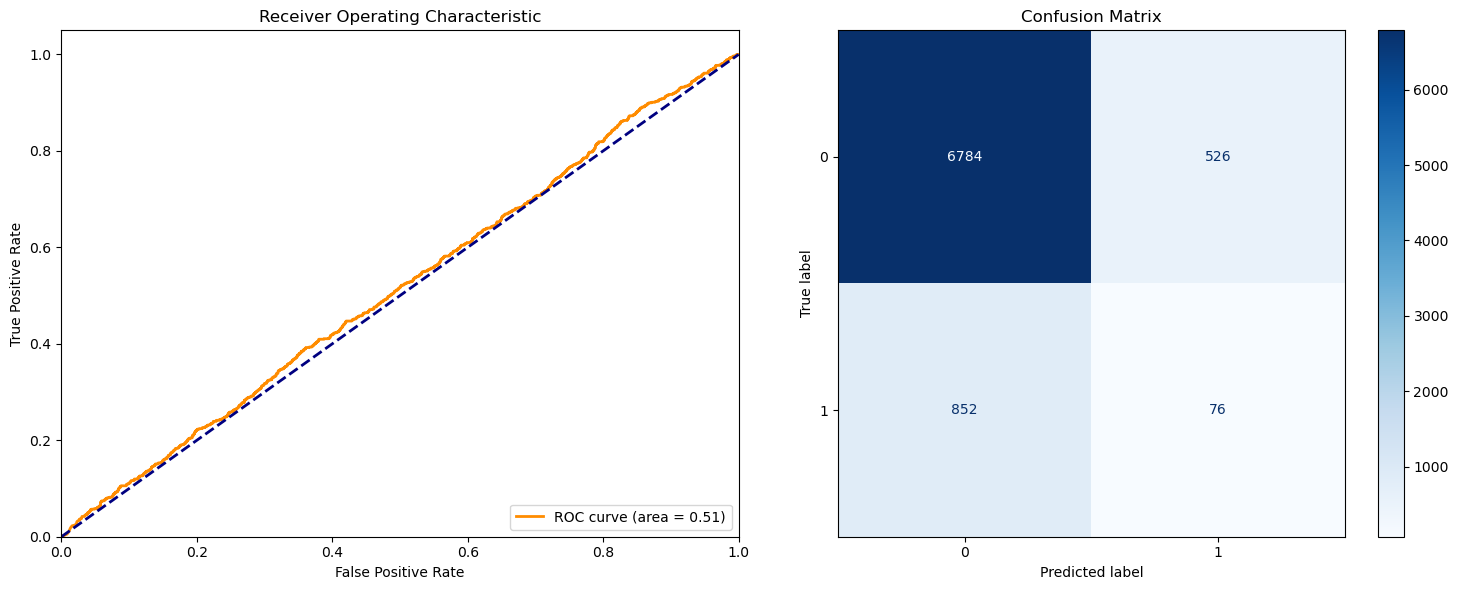

In [349]:

results_nb = eval_model(y_test, predictions_nb, y_pred_probs_nb)
results_nb

Logistic regression is a statistical model used mainly for binary classification so suits this task well. The algorithm uses the logistic function to squeeze the output of a linear equation between 0 and 1. This output is interpreted as the probability of the dependent variable belonging to a particular class. 

In [103]:
def train_and_predict_lr(X_train: np.ndarray, y_train: np.ndarray, 
                         X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray, GridSearchCV]:
    """
    Train a Logistic Regression classifier using GridSearchCV and predict on test data.

    This function trains a Logistic Regression classifier using a grid search to find the best
    regularization strength ('C') and penalty type. The 'C' values are tested from 0.1 to 2.0 
    in increments of 0.1. The penalty used is 'l2'. It returns the predictions on the test data, 
    the probability estimates of the positive class, and the GridSearchCV object for further 
    inspection.

    Parameters:
      X_train (np.ndarray): Training data features.
      y_train (np.ndarray): Training data labels.
      X_test (np.ndarray): Test data features.

    Returns:
      Tuple[np.ndarray, np.ndarray, GridSearchCV]: A tuple containing the predicted labels 
        for the test data, probability estimates of the positive class for the test data, 
        and the trained GridSearchCV object.
    """

    lr = LogisticRegression(max_iter=1000)

    param_grid = {
        'C': [i / 10.0 for i in range(1, 21)],
        'penalty': ['l2']
    }

    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_lr = grid_search.best_estimator_

    predictions = best_lr.predict(X_test)
    y_pred_probs = best_lr.predict_proba(X_test)[:, 1]

    return predictions, y_pred_probs, grid_search

In [ ]:
predictions_lr, y_pred_probs_lr, grid_search_lr = train_and_predict_lr(X_train, y_train, X_test)

{'AUC': 0.5123915043162413,
 'F1': 0.10039630118890355,
 'Precision': 0.1296928327645051,
 'Recall': 0.08189655172413793,
 'AUC Precision Recall': 0.11761800412894091,
 'Accuracy': 0.8346686088856519}

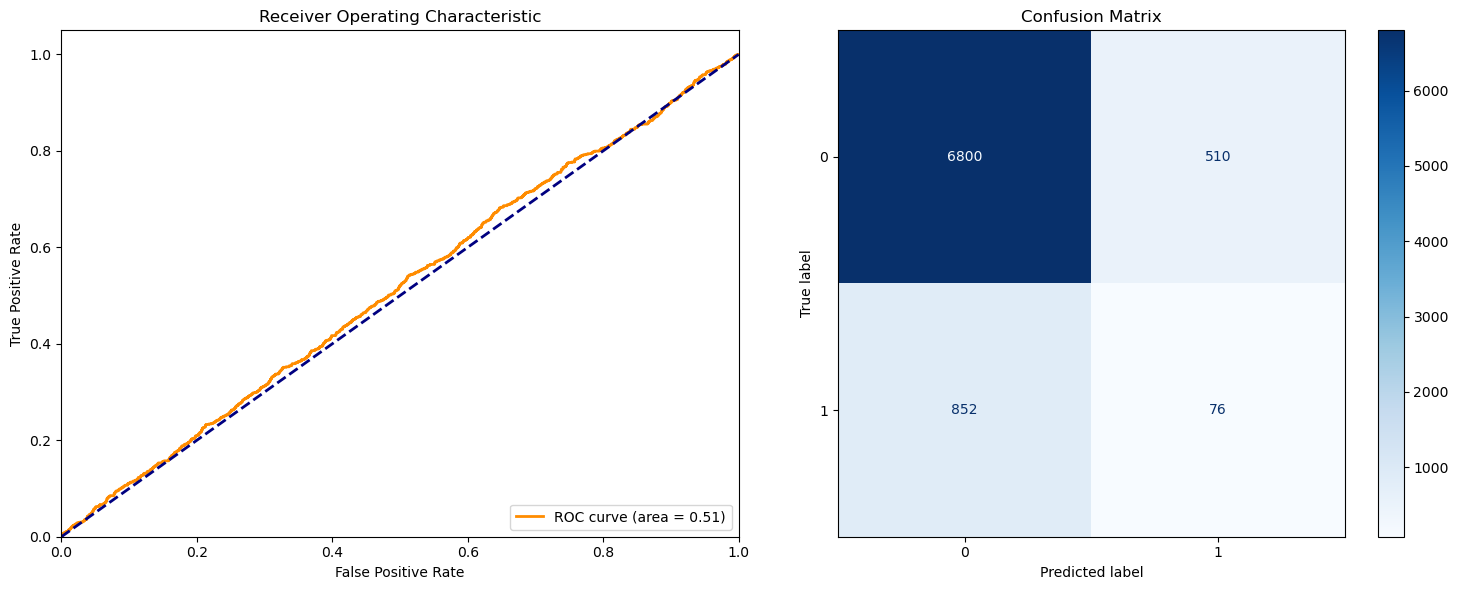

In [350]:

results_lr = eval_model(y_test, predictions_lr, y_pred_probs_lr)
results_lr

Having tried some basic models, with hyperparmater tuning to try give each the best possible chance of producing good results, they all struggle to deal with the 'yes' labeled data the next step is to try something more powerful. From my experiance with tabular data Gradient boosting models are one of if not the most powerful. Three types will be trailed, from there it will be compared to the above methods and the most accurate I will prepare some more complex feature engineering for to try boost its preformance.

In [170]:
def train_and_predict_xgb(X_train: np.ndarray, y_train: np.ndarray, 
                          X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Train an XGBoost classifier and predict on test data.

    This function trains an XGBoost classifier using the provided training data. It fits the 
    model on the training data and then makes predictions on the test data. It returns the 
    predictions and the probability estimates of the positive class for the test data. Note that
    this implementation does not use GridSearchCV for hyperparameter tuning.

    Parameters:
      X_train (np.ndarray): Training data features.
      y_train (np.ndarray): Training data labels.
      X_test (np.ndarray): Test data features.

    Returns:
      Tuple[np.ndarray, np.ndarray]: A tuple containing the predicted labels for the test data 
        and probability estimates of the positive class for the test data.
    """

    xgb = XGBClassifier(enable_categorical=True, eval_metric='logloss')

    xgb.fit(X_train, y_train)

    predictions = xgb.predict(X_test)
    y_pred_probs = xgb.predict_proba(X_test)[:, 1]

    return predictions, y_pred_probs

In [352]:
X_train, X_test, y_train, y_test = split_data(bank_df, 'y')
predictions_xgb, y_pred_probs_xgb = train_and_predict_xgb(X_train, y_train, X_test)

{'AUC': 0.9449826642766168,
 'F1': 0.58603066439523,
 'Precision': 0.6194477791116446,
 'Recall': 0.5560344827586207,
 'AUC Precision Recall': 0.6190171702102119,
 'Accuracy': 0.9115076474872542}

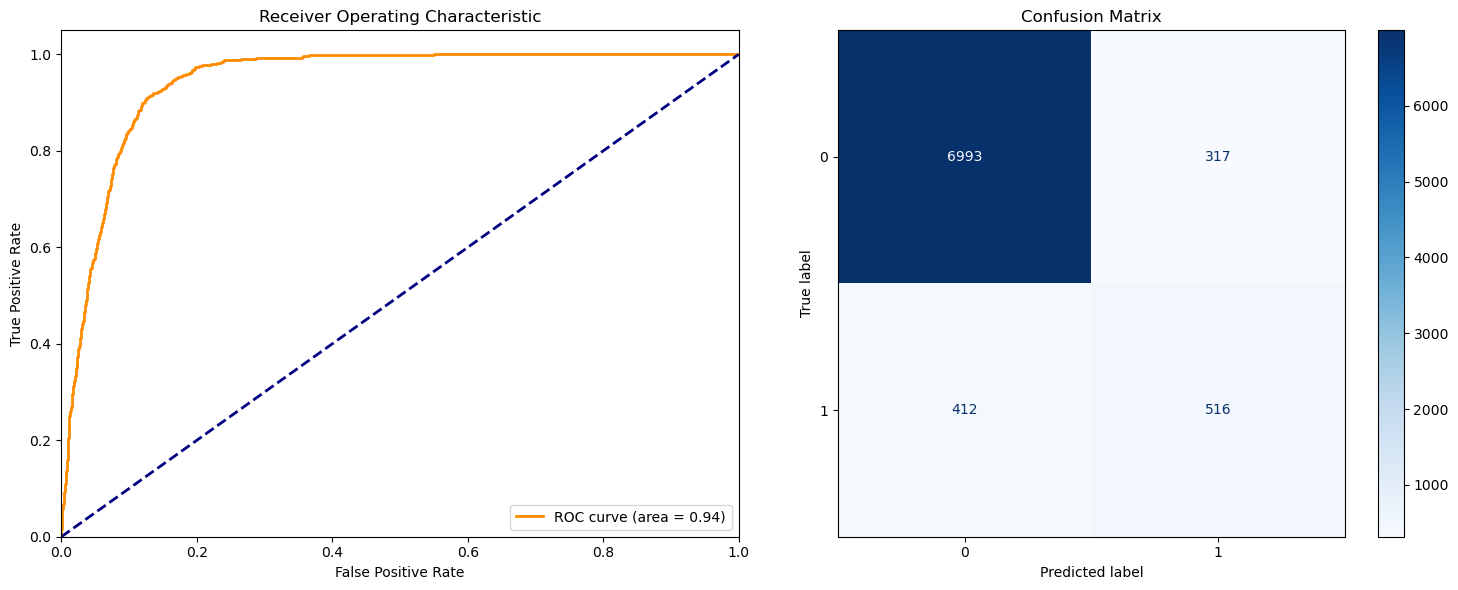

In [353]:

results_xgb = eval_model(y_test, predictions_xgb, y_pred_probs_xgb)
results_xgb

In [172]:
def train_and_predict_lgbm(X_train: np.ndarray, y_train: np.ndarray, 
                           X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Train a LightGBM classifier and predict on test data.

    This function trains a LightGBM classifier with default parameters and makes predictions
    on the test data. It returns the predicted labels and the probability estimates of the
    positive class for the test data.

    Parameters:
      X_train (np.ndarray): Training data features.
      y_train (np.ndarray): Training data labels.
      X_test (np.ndarray): Test data features.

    Returns:
      Tuple[np.ndarray, np.ndarray]: Predicted labels and probability estimates for test data.
    """

    lgbm = lgb.LGBMClassifier(enable_categorical=True, eval_metric='logloss')
    lgbm.fit(X_train, y_train)
    predictions = lgbm.predict(X_test)
    y_pred_probs = lgbm.predict_proba(X_test)[:, 1]

    return predictions, y_pred_probs

[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 3712, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112656 -> initscore=-2.063898
[LightGBM] [Info] Start training from score -2.063898
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: eval_metric


{'AUC': 0.9507888048964573,
 'F1': 0.58603066439523,
 'Precision': 0.6194477791116446,
 'Recall': 0.5560344827586207,
 'AUC Precision Recall': 0.6610493110852056,
 'Accuracy': 0.9115076474872542}

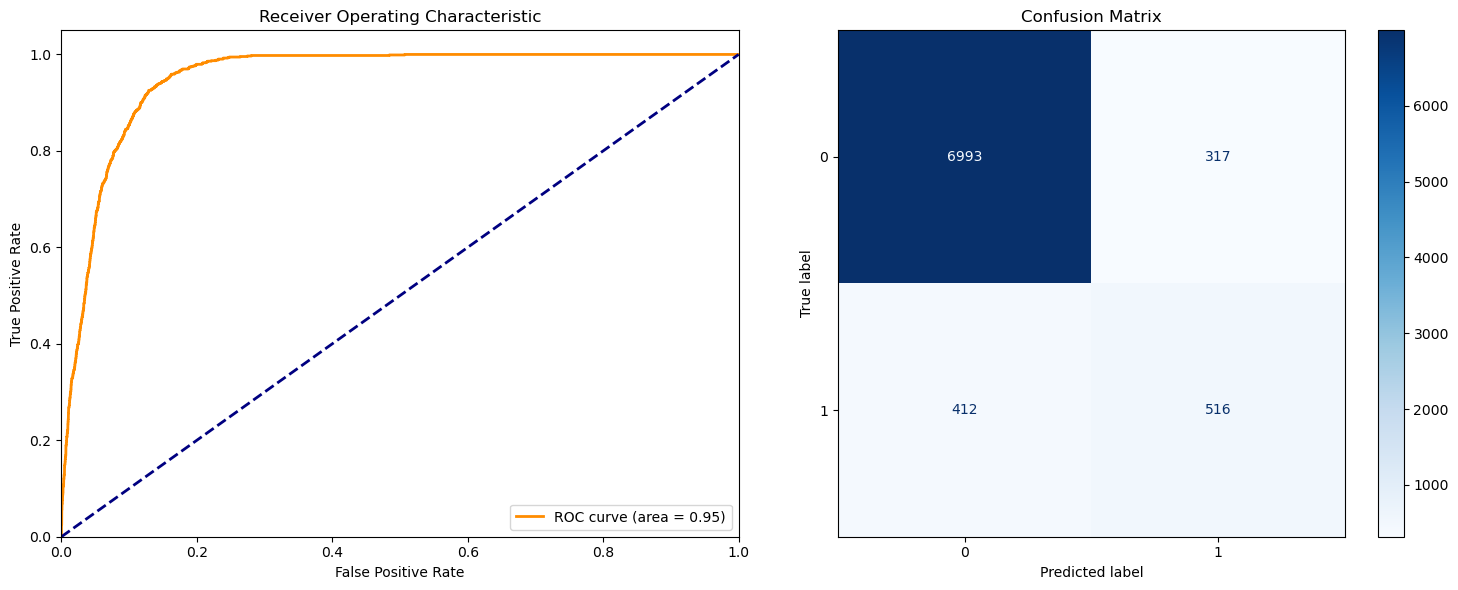

In [354]:
predictions_lgbm, y_pred_probs_lgbm = train_and_predict_lgbm(X_train, y_train, X_test)
results_lgbm = eval_model(y_test, predictions_xgb, y_pred_probs_lgbm)
results_lgbm

In [358]:
def train_and_predict_catboost(X_train: np.ndarray, y_train: np.ndarray, 
                               X_test: np.ndarray, params: Optional[Dict] = {}) -> Tuple[np.ndarray, np.ndarray]:
    """
    Train a CatBoost classifier and predict on test data.

    This function trains a CatBoost classifier with the provided parameters (if any) and
    makes predictions on the test data. It returns the predicted labels and the probability
    estimates of the positive class for the test data. The categorical columns used for 
    training are extracted from a global variable 'categorical_columns'.

    Parameters:
      X_train (np.ndarray): Training data features.
      y_train (np.ndarray): Training data labels.
      X_test (np.ndarray): Test data features.
      params (Optional[Dict]): Parameters for the CatBoost classifier.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: Predicted labels and probability estimates for test data.
    """

    cat_list = categorical_columns.to_list()
    if 'y' in cat_list:
      cat_list.remove('y')
    catboost = CatBoostClassifier(eval_metric='Logloss', cat_features=cat_list, **params)
    catboost.fit(X_train, y_train, verbose=False)
    predictions = catboost.predict(X_test)
    y_pred_probs = catboost.predict_proba(X_test)[:, 1]

    return predictions, y_pred_probs


{'AUC': 0.9512180704278503,
 'F1': 0.5952242283051834,
 'Precision': 0.6476552598225602,
 'Recall': 0.5506465517241379,
 'AUC Precision Recall': 0.6545026724307103,
 'Accuracy': 0.9156348628307842}

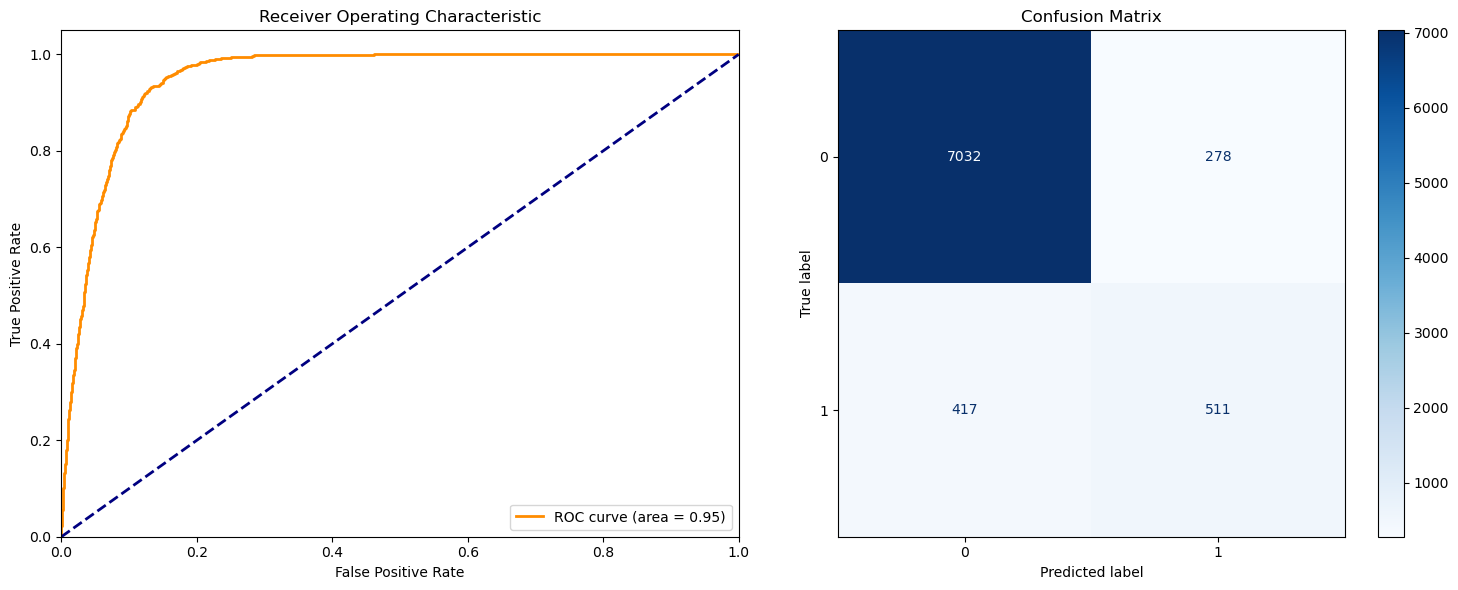

In [359]:
predictions_catboost, y_pred_probs_catboost = train_and_predict_catboost(X_train, y_train, X_test)
results_catboost = eval_model(y_test, predictions_catboost, y_pred_probs_catboost)
results_catboost

Having compared all the models and metrics it was decided to proceed with Catboost, there were several reasons for this. The first being that across all the metrics it scores the best aside from Recall. The data being used for features is a mixture of categorical and continuous, something Catboost is known to preform well on. The Gradient bosting models have in build functions to deal with class imbalance. Due to the tree make up of these models the feature importance can easily be extracted, something that is a requirement of this task. Finally I have personal experiance with this model so can quickly build an optimisation system for it. Below is an intial optuna optimisation.

In [183]:


def objective_inital_catboost(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna study to optimize CatBoost classifier.

    Parameters:
      trial (optuna.Trial): An Optuna trial object.

    Returns:
      float: Log loss of the model on test data.
    """
    
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'task_type': 'GPU',
    }
    cat_list = categorical_columns.to_list()
    cat_list.remove('y')
    model = CatBoostClassifier(**param, 
                               loss_function='Logloss', 
                               eval_metric='Logloss', 
                               verbose=0,
                               use_best_model=True,
                               cat_features=cat_list)
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100)
    preds = model.predict_proba(X_test)
    return log_loss(y_test, preds)

study = optuna.create_study(direction='minimize')


study.optimize(objective_inital_catboost, n_trials=100)  

best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2023-11-10 01:06:04,771] A new study created in memory with name: no-name-0a2775f9-bf05-4058-b609-c56468a08bd7
[I 2023-11-10 01:06:51,408] Trial 0 finished with value: 0.17710470568768347 and parameters: {'iterations': 937, 'depth': 4, 'learning_rate': 0.03782059213262112, 'random_strength': 11, 'bagging_temperature': 0.30889374041142614, 'od_type': 'Iter', 'l2_leaf_reg': 1.651954778129977}. Best is trial 0 with value: 0.17710470568768347.
[I 2023-11-10 01:07:25,791] Trial 1 finished with value: 0.1838653537293224 and parameters: {'iterations': 835, 'depth': 9, 'learning_rate': 0.22698713810964244, 'random_strength': 97, 'bagging_temperature': 0.11058578388754048, 'od_type': 'IncToDec', 'l2_leaf_reg': 0.00010944070927029009}. Best is trial 0 with value: 0.17710470568768347.
[I 2023-11-10 01:07:45,480] Trial 2 finished with value: 0.17583013302380318 and parameters: {'iterations': 324, 'depth': 8, 'learning_rate': 0.04138875754986562, 'random_strength': 22, 'bagging_temperature': 0.8

Best parameters: {'iterations': 624, 'depth': 10, 'learning_rate': 0.13520264290116002, 'random_strength': 7, 'bagging_temperature': 0.6498981773262688, 'od_type': 'IncToDec', 'l2_leaf_reg': 9.440659211883807}


In [360]:
best_params = {'iterations': 624, 'depth': 10, 'learning_rate': 0.13520264290116002, 'random_strength': 7, 'bagging_temperature': 0.6498981773262688, 'od_type': 'IncToDec', 'l2_leaf_reg': 9.440659211883807}

{'AUC': 0.9493328105099296,
 'F1': 0.5782431646305991,
 'Precision': 0.6283185840707964,
 'Recall': 0.5355603448275862,
 'AUC Precision Recall': 0.6503380178982473,
 'Accuracy': 0.9119932022335518}

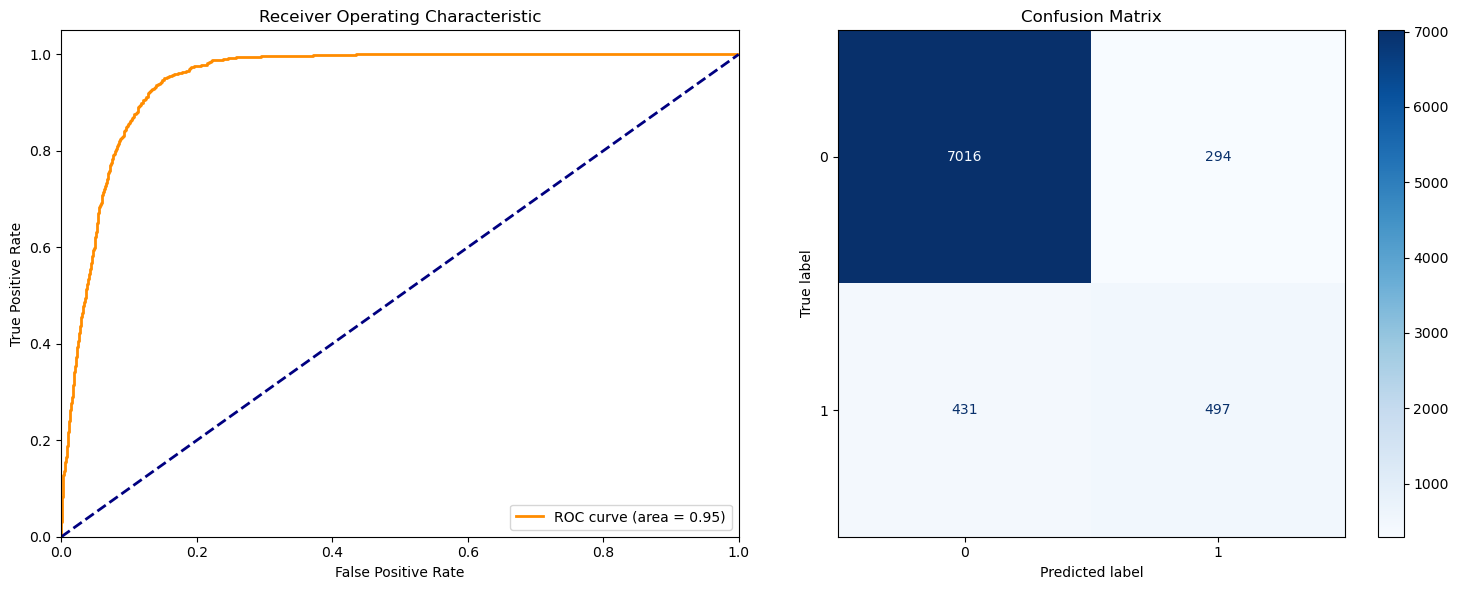

In [361]:
predictions_catboost, y_pred_probs_catboost = train_and_predict_catboost(X_train, y_train, X_test, best_params)
results_catboost = eval_model(y_test, predictions_catboost, y_pred_probs_catboost)
results_catboost

Having tried the usual hyperparameters, lets trail some parameters specifically designed to deal with the models class imbalance.

In [202]:

def objective_class_balance(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna study to optimize CatBoost classifier.

    Parameters:
      trial (optuna.Trial): An Optuna trial object.

    Returns:
      float: Log loss of the model on test data.
    """
    
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['SqrtBalanced', 'Balanced', None]),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'task_type': 'GPU',
    }
    cat_list = categorical_columns.to_list()
    cat_list.remove('y')
    model = CatBoostClassifier(**param, 
                               loss_function='Logloss', 
                               eval_metric='Logloss', 
                               verbose=0,
                               use_best_model=True,
                               cat_features=cat_list)
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100)
    preds = model.predict_proba(X_test)
    return log_loss(y_test, preds)

study = optuna.create_study(direction='minimize')


study.optimize(objective_class_balance, n_trials=25)  

best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2023-11-13 15:13:56,150] A new study created in memory with name: no-name-b0911048-3247-42e0-967b-b92c65ae6b11
[I 2023-11-13 15:14:23,443] Trial 0 finished with value: 0.21083894797286024 and parameters: {'iterations': 985, 'depth': 9, 'learning_rate': 0.2732662095875384, 'random_strength': 23, 'bagging_temperature': 0.5174464522924378, 'od_type': 'IncToDec', 'auto_class_weights': 'SqrtBalanced', 'l2_leaf_reg': 0.00019058345502654344}. Best is trial 0 with value: 0.21083894797286024.
[I 2023-11-13 15:14:49,007] Trial 1 finished with value: 0.20312937680854243 and parameters: {'iterations': 511, 'depth': 4, 'learning_rate': 0.2677804027340569, 'random_strength': 51, 'bagging_temperature': 0.22261011622962257, 'od_type': 'Iter', 'auto_class_weights': 'SqrtBalanced', 'l2_leaf_reg': 7.669437154105998}. Best is trial 1 with value: 0.20312937680854243.
[I 2023-11-13 15:14:50,719] Trial 2 finished with value: 0.2028699099705063 and parameters: {'iterations': 126, 'depth': 5, 'learning_rate

Best parameters: {'iterations': 377, 'depth': 6, 'learning_rate': 0.10068805546427806, 'random_strength': 7, 'bagging_temperature': 0.7293018175033783, 'od_type': 'Iter', 'auto_class_weights': 'SqrtBalanced', 'l2_leaf_reg': 0.5914030210870858}


In [362]:
best_params = {'iterations': 377, 'depth': 6, 'learning_rate': 0.10068805546427806, 'random_strength': 7, 'bagging_temperature': 0.7293018175033783, 'od_type': 'Iter', 'auto_class_weights': 'SqrtBalanced', 'l2_leaf_reg': 0.5914030210870858}

{'AUC': 0.9512450469361762,
 'F1': 0.6587719298245615,
 'Precision': 0.5554733727810651,
 'Recall': 0.8092672413793104,
 'AUC Precision Recall': 0.6568754437053826,
 'Accuracy': 0.9055596018451081}

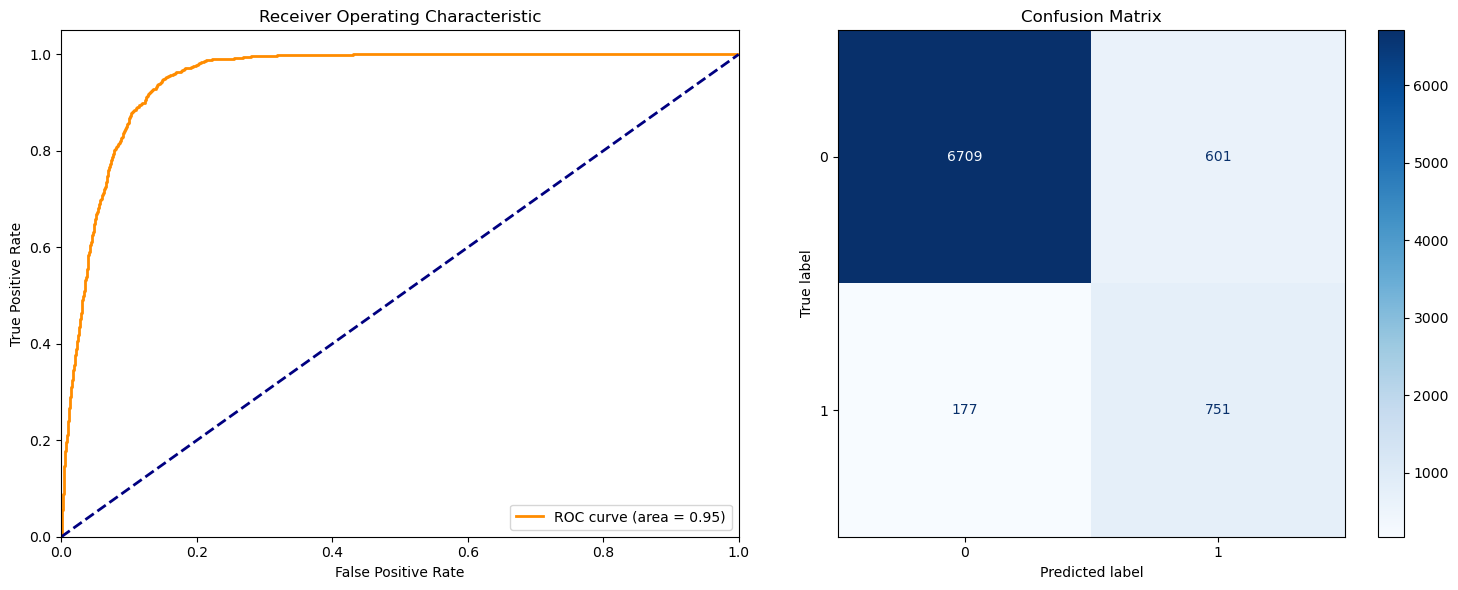

In [363]:
predictions_catboost, y_pred_probs_catboost = train_and_predict_catboost(X_train, y_train, X_test, best_params)
results_catboost = eval_model(y_test, predictions_catboost, y_pred_probs_catboost)
results_catboost

Some improvement but lets trial an undersampling method.

In [ ]:
def train_and_predict_catboost_rus(X_train: np.ndarray, y_train: np.ndarray, 
                                   X_test: np.ndarray, params: Optional[Dict] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Train a CatBoost classifier with Random Under Sampling (RUS) and predict on test data.

    This function trains a CatBoost classifier on data resampled using RUS. It returns the 
    predicted labels and the probability estimates of the positive class for the test data. 
    The categorical columns used for training are extracted from a global variable 
    'categorical_columns'.

    Parameters:
      X_train (np.ndarray): Training data features.
      y_train (np.ndarray): Training data labels.
      X_test (np.ndarray): Test data features.
      params (Optional[Dict]): Parameters for the CatBoost classifier.

    Returns:
      Tuple[np.ndarray, np.ndarray]: Predicted labels and probability estimates for test data.
    """

    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    cat_list = categorical_columns.to_list()
    cat_list.remove('y')
    catboost = CatBoostClassifier(eval_metric='Logloss', cat_features=cat_list, **params)
    catboost.fit(X_train_resampled, y_train_resampled, verbose=False)
    predictions = catboost.predict(X_test)
    y_pred_probs = catboost.predict_proba(X_test)[:, 1]

    return predictions, y_pred_probs


{'AUC': 0.9512180704278503,
 'F1': 0.5952242283051834,
 'Precision': 0.6476552598225602,
 'Recall': 0.5506465517241379,
 'AUC Precision Recall': 0.6545026724307103,
 'Accuracy': 0.9156348628307842}

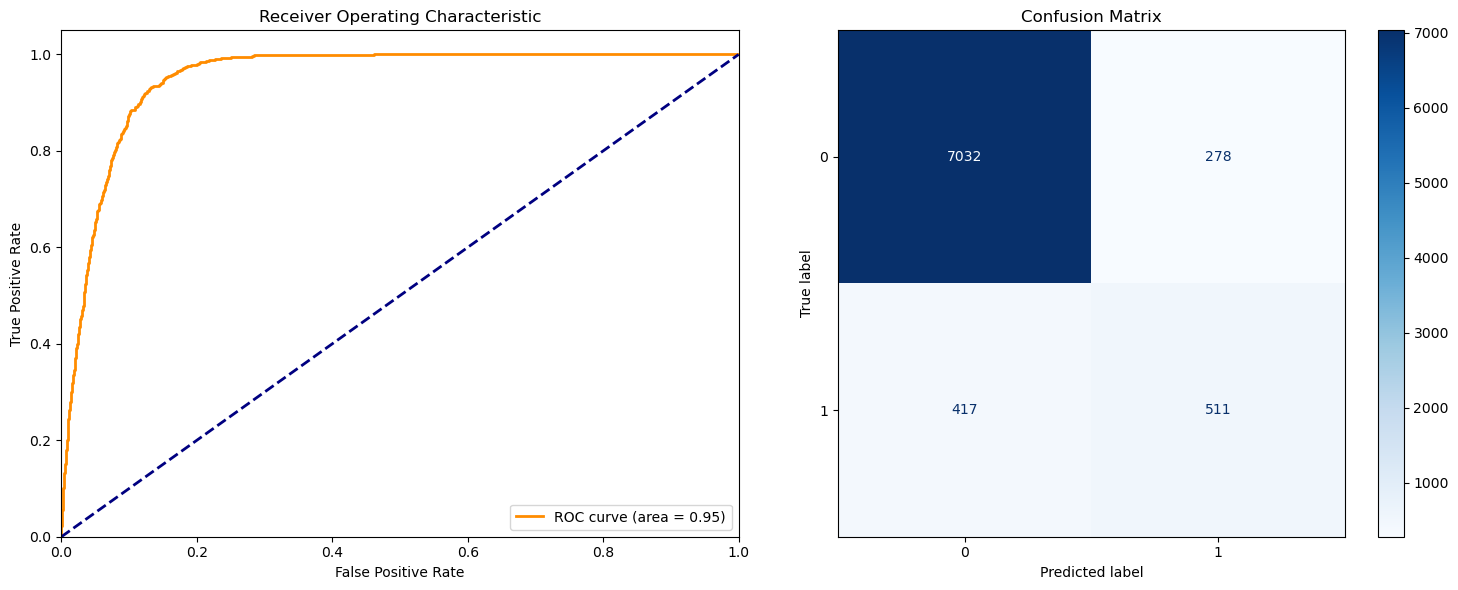

In [364]:
predictions_catboost_undersample, y_pred_probs_catboost_undersample = train_and_predict_catboost(X_train, y_train, X_test)
results_catboost_undersample = eval_model(y_test, predictions_catboost_undersample, y_pred_probs_catboost_undersample)
results_catboost_undersample

Ok so these have made some big steps but recall is still not quite where we want it, lets try adjusting the scale_pos_weight, this will give a higher weight to the minority class and is designed for binary classification problems.

{'AUC': 0.9517786805981415,
 'F1': 0.6452371618972952,
 'Precision': 0.5070856438693777,
 'Recall': 0.8868534482758621,
 'AUC Precision Recall': 0.657180648491947,
 'Accuracy': 0.8901432386501578}

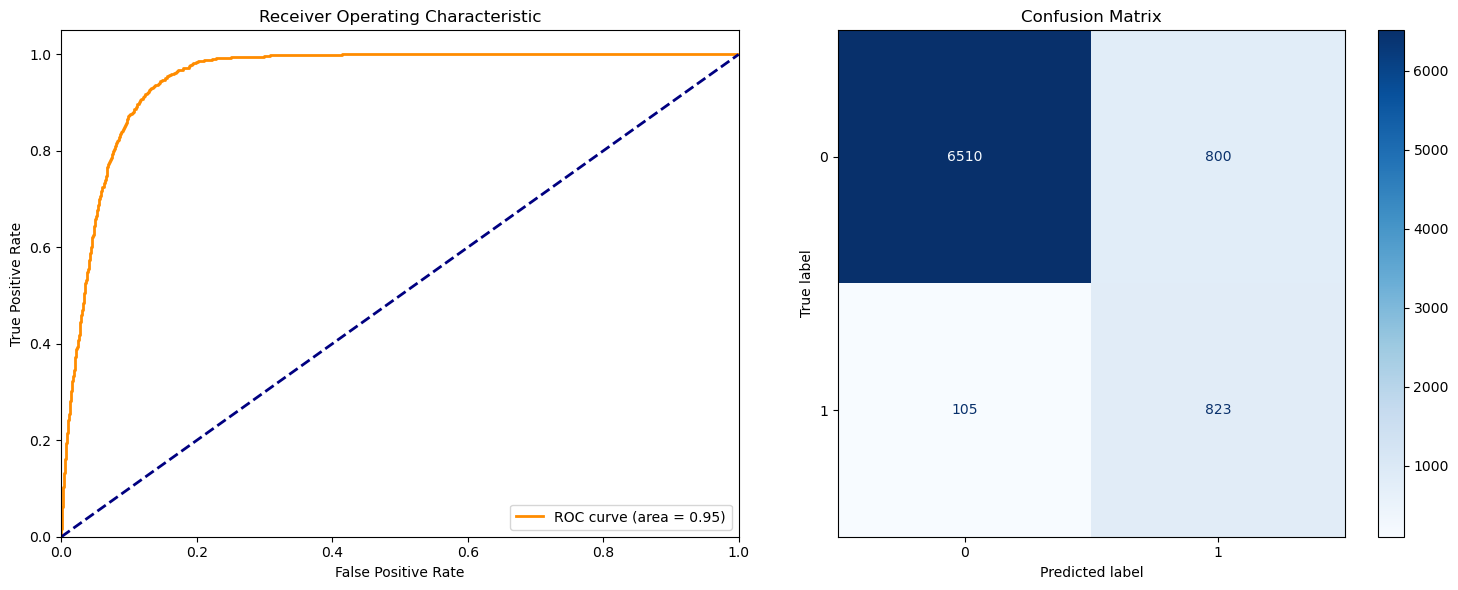

In [365]:
predictions_catboost, y_pred_probs_catboost = train_and_predict_catboost(X_train, y_train, X_test, {'scale_pos_weight':5})
results_catboost = eval_model(y_test, predictions_catboost, y_pred_probs_catboost)
results_catboost

{'AUC': 0.9523297089485354,
 'F1': 0.6626245127760936,
 'Precision': 0.55394641564084,
 'Recall': 0.8243534482758621,
 'AUC Precision Recall': 0.6582112912204541,
 'Accuracy': 0.9054382131585337}

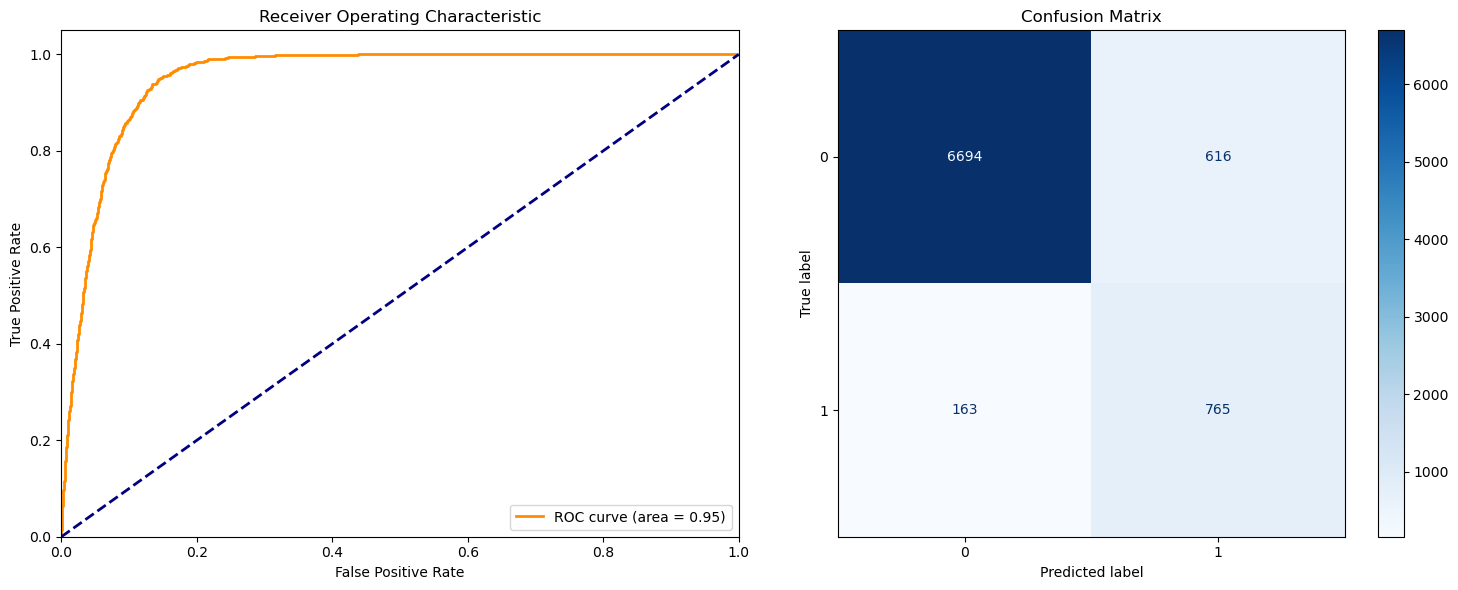

In [366]:
predictions_catboost, y_pred_probs_catboost = train_and_predict_catboost(X_train, y_train, X_test, {'scale_pos_weight':3})
results_catboost = eval_model(y_test, predictions_catboost, y_pred_probs_catboost)
results_catboost

Ok so this appears to be helping alot, but gradient boosters do like to under and overfit so lets try to bring that back with a custom metric for optuna. We are also going to target the F1 score for this step and use the most optimal model as our final. Also lets upsample the minority class to try help the issue even further. 

In [396]:

def calculate_weighted_f1_score(train_accuracy: float, test_accuracy: float) -> float:
    '''
    Calculate a weighted F1 score that considers both the accuracy and the disparity 
    between training and testing accuracies.

    The formula combines the root mean square error (RMSE) of the difference between 
    training and testing accuracies, and the weighted test accuracy. The RMSE component 
    is weighted four times less than the test accuracy.

    Args:
    train_accuracy (float): Mean accuracy of the model on the training set.
    test_accuracy (float): Mean accuracy of the model on the testing/validation set.

    Returns:
    float: A weighted F1 score reflecting both accuracy and overfitting/underfitting.
    '''
    rmse_disparity = np.sqrt((test_accuracy - train_accuracy)**2)
    weighted_test_accuracy = 4 * (1 - test_accuracy)
    return rmse_disparity + weighted_test_accuracy


In [236]:


def encode_categorical_columns(train_df: pd.DataFrame, test_df: pd.DataFrame,
                             categorical_columns: List, target: str) -> pd.DataFrame:
    """
    Encodes categorical columns in the training and test dataframes using the same
    mappings to avoid data leakage.

    Args:
        train_df (pd.DataFrame): The training dataframe.
        test_df (pd.DataFrame): The test dataframe.
        categorical_columns (list): List of column names in the dataframe that are categorical.
        target (str): Name of the target column.

    Returns:
        pd.DataFrame, pd.DataFrame: The encoded training and test dataframes.
    """
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()

    for column in categorical_columns:
        if column != target:

            encoder.fit(encoded_train_df[[column]])
            encoded_feature_names = encoder.get_feature_names_out([column])

            encoded_data_train = encoder.transform(encoded_train_df[[column]])
            for i, feature_name in enumerate(encoded_feature_names):
                encoded_train_df[feature_name] = encoded_data_train[:, i]
            

            encoded_data_test = encoder.transform(encoded_test_df[[column]])
            for i, feature_name in enumerate(encoded_feature_names):
                encoded_test_df[feature_name] = encoded_data_test[:, i]

            encoded_train_df = encoded_train_df.drop(column, axis=1)
            encoded_test_df = encoded_test_df.drop(column, axis=1)

    return encoded_train_df, encoded_test_df


In [251]:
def reverse_one_hot(encoded_df: pd.DataFrame, original_df: pd.DataFrame,
                     categorical_columns: list)-> pd.DataFrame:
    """
    Optimised function to revert One-Hot Encoded columns back to the original 
    categorical format.

    Args:
        encoded_df (pd.DataFrame): The dataframe with One-Hot Encoded features.
        original_df (pd.DataFrame): The original dataframe before encoding.
        categorical_columns (list): List of original categorical column names.

    Returns:
        pd.DataFrame: The dataframe with reverted categorical columns.
    """
    reverted_df = encoded_df.copy()
    
    for column in categorical_columns:

        encoded_columns = [col for col in encoded_df if col.startswith(column + '_')]
        category_values = [col.split(column + '_')[1] for col in encoded_columns]

        for cat_value, encoded_col in zip(category_values, encoded_columns):
            reverted_df.loc[reverted_df[encoded_col] == 1, column] = cat_value

        if column in original_df:
            reverted_df[column].fillna(original_df[column].mode()[0], inplace=True)

        reverted_df.drop(encoded_columns, axis=1, inplace=True)
        if column != 'y':
            reverted_df[column] = reverted_df[column].astype('category')
    return reverted_df



In [ ]:
def objective_final(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna study to optimize CatBoost classifier.

    Parameters:
      trial (optuna.Trial): An Optuna trial object.

    Returns:
      float: Log loss of the model on test data.
    """
    cat_list = categorical_columns.to_list()
    if 'y' in cat_list:
      cat_list.remove('y')
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'task_type': 'GPU',
    }
    smote_space = {'sampling_strategy': trial.suggest_uniform('sampling_strategy', 0.5, 1)}

    X_train_encoded, _ = encode_categorical_columns(X_train, X_test,categorical_columns, 'y')
    smt = SMOTE(random_state=42, **smote_space) 
    x_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)

    
    x_train_smt = reverse_one_hot(x_train_smt, X_train, categorical_columns)
    model = CatBoostClassifier(**param, 
                               loss_function='Logloss', 
                               eval_metric='Logloss', 
                               verbose=0,
                               cat_features=cat_list)
    model.fit(x_train_smt, y_train_smt, early_stopping_rounds=100)
    preds_train = model.predict(X_train[x_train_smt.columns])
    preds_valid = model.predict(X_test[x_train_smt.columns])
    train_f1_mean = f1_score(y_train, preds_train)
    valid_f1_mean = f1_score(y_test, preds_valid)
    
    return calculate_weighted_f1_score(train_f1_mean, valid_f1_mean)

study = optuna.create_study(direction='minimize')

study.optimize(objective_final, n_trials=25)  

best_params = study.best_params
print(f"Best parameters: {best_params}")

Cell accidently re ran, the tuning phase can take up to 30 mins. The results from this tune can be seen below, note if you do not have GPU access you may need to remove the task_type parameter.

In [271]:
with open('hyperparams/best_params.json', 'w') as json_file:
    json.dump(best_params, json_file)
best_params

{'iterations': 269,
 'depth': 8,
 'scale_pos_weight': 4,
 'learning_rate': 0.06579981825909156,
 'random_strength': 17,
 'bagging_temperature': 0.7163605605176038,
 'od_type': 'Iter',
 'l2_leaf_reg': 0.33342822185707843}

In [367]:
best_params = {'iterations': 269, 'depth': 8, 'scale_pos_weight': 4, 'learning_rate': 0.06579981825909156, 'random_strength': 17, 'bagging_temperature': 0.7163605605176038, 'od_type': 'Iter', 'l2_leaf_reg': 0.33342822185707843, 'sampling_strategy': 0.5680392344380994}

In [379]:
def full_catboost_train(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray,
                        categorical_columns: List[str], catboost_params: Optional[Dict] = None,
                        smote_space: Optional[Dict] = None) -> Tuple[np.ndarray, np.ndarray, CatBoostClassifier]:
    """
    Train a CatBoost classifier with SMOTE resampling and predict on test data.

    This function encodes categorical columns, applies SMOTE for resampling, trains a 
    CatBoost classifier with the given parameters, and makes predictions on the test data.
    It returns the predicted labels, the probability estimates for the test data, and the
    trained CatBoost model.

    Parameters:
      X_train (np.ndarray): Training data features.
      y_train (np.ndarray): Training data labels.
      X_test (np.ndarray): Test data features.
      categorical_columns (List[str]): List of categorical column names.
      catboost_params (Optional[Dict]): Parameters for the CatBoost classifier.
      smote_space (Optional[Dict]): Parameters for SMOTE.

    Returns:
      Tuple[np.ndarray, np.ndarray, CatBoostClassifier]: Predicted labels, probability 
        estimates for test data, and the CatBoost model.
    """
    cat_list = categorical_columns.to_list()
    if 'y' in cat_list:
        cat_list.remove('y')
    X_train_encoded, _ = encode_categorical_columns(X_train, X_test,cat_list, 'y')
    smt = SMOTE(random_state=42, **smote_space) 
    x_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)

    
    x_train_smt = reverse_one_hot(x_train_smt, X_train, categorical_columns)
    
    catboost = CatBoostClassifier(**catboost_params, 
                               loss_function='Logloss', 
                               eval_metric='Logloss', 
                               verbose=0,
                               cat_features=cat_list)
    catboost.fit(x_train_smt, y_train_smt, early_stopping_rounds=100)
    predictions = catboost.predict(X_test[x_train_smt.columns])
    y_pred_probs = catboost.predict_proba(X_test[x_train_smt.columns])[:, 1]
    return predictions, y_pred_probs, catboost

In [389]:
catboost_params = best_params.copy()
catboost_params.pop('sampling_strategy', None)
smote_space = {}
smote_space['sampling_strategy'] = best_params['sampling_strategy']
predictions, y_pred_probs, catboost = full_catboost_train(X_train, y_train, X_test,X_train.select_dtypes(include=['category', 'object']).columns, catboost_params, smote_space)

{'AUC': 0.9427122151988302,
 'F1': 0.619482496194825,
 'Precision': 0.4788235294117647,
 'Recall': 0.8771551724137931,
 'AUC Precision Recall': 0.6060533808863078,
 'Accuracy': 0.8786113134255887}

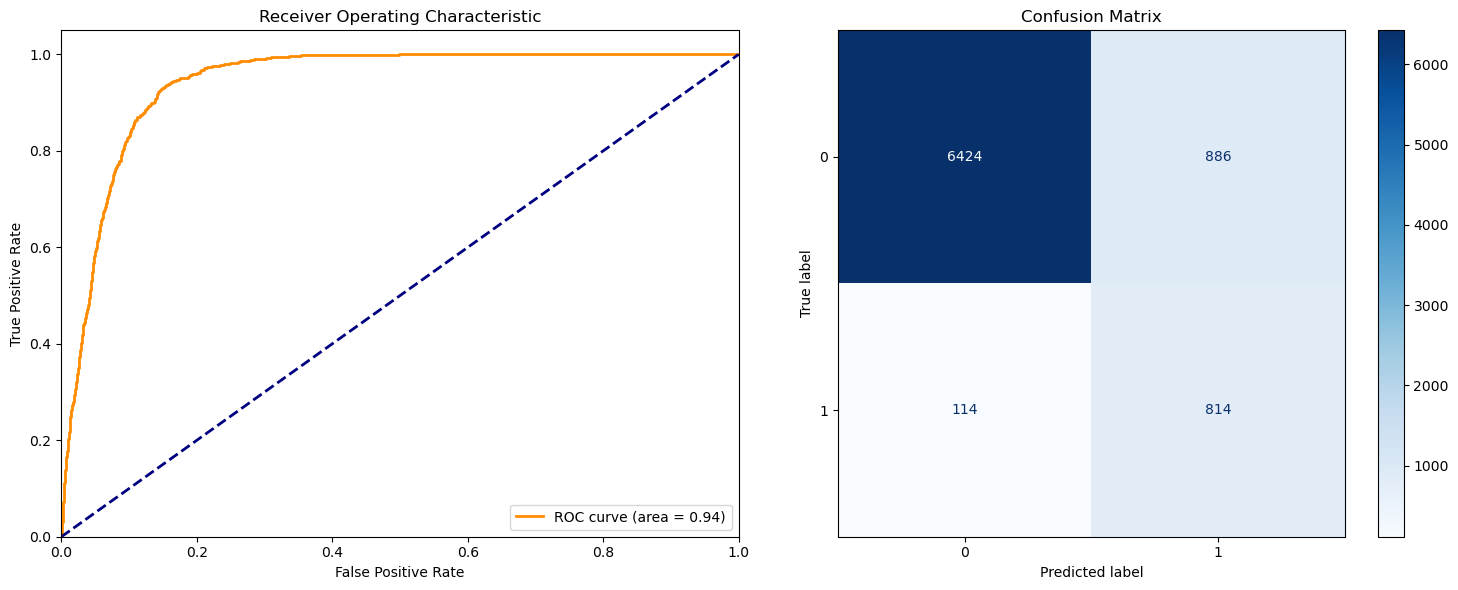

In [381]:
results_catboost = eval_model(y_test, predictions, y_pred_probs)
results_catboost

After all the fine tuning the full results for the final model can be seen above, we can see huge improvments in the recall score aswell as a step in the F1. However this caused some degredation to the accuracy an the precision score. This is to be expected as the model is now no longer overfiting to the majority data set and instead is incorrectly predicting the majority as minority. This model however is much better overall as it finally predicting a good number of the minority while maintaining good scores in many of the metrics.

In [393]:
with open('models/catboost.pkl', 'wb') as file:
        pickle.dump(catboost, file)

In [261]:
def plot_feature_importance(model, feature_names):
    """
    Plot the feature importances of a CatBoost model.

    Args:
    model (CatBoost model): The trained CatBoost model.
    feature_names (list of str): List of feature names.

    Returns:
    A bar plot showing the feature importances.
    """

    importances = model.feature_importances_

    indices = np.argsort(importances)[::-1]

    names = [feature_names[i] for i in indices]


    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), names, rotation=90)
    plt.show()

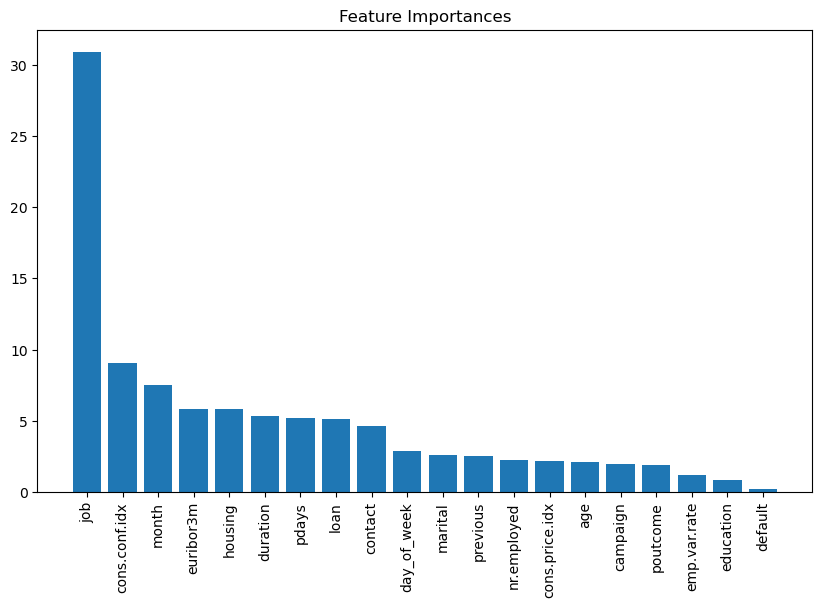

In [276]:
plot_feature_importance(catboost, X_train.columns)

One of the use full features of gradient boosting is the feature importance metric, CatBoost calculates this by replacing a feature in a dataset with a random permutation of its values and measuring the change in the model's accuracy. This allows the above plot to be created showing that for this model the Job is by far the most important feature. Finally to complete the task lets take the top 5 features that Catboost has found important and plot them to produce a model with only 5 features.

In [ ]:
def get_top_features(model, feature_names, top_n=5):
    """
    Get the top N features based on feature importance.

    Args:
    model (CatBoost model): The trained CatBoost model.
    feature_names (list of str): List of feature names.
    top_n (int): Number of top features to select.

    Returns:
    List of top N feature names.
    """

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = [feature_names[i] for i in indices[:top_n]]
    return top_features

In [ ]:
top_five_features = get_top_features(catboost, X_train.columns)
top_five_features

['job', 'cons.conf.idx', 'month', 'euribor3m', 'housing']

In [291]:
catboost_params = best_params.copy()
catboost_params.pop('sampling_strategy', None)
smote_space = {}
smote_space['sampling_strategy'] = best_params['sampling_strategy']

predictions, y_pred_probs, catboost = full_catboost_train(X_train[top_five_features], y_train, X_test[top_five_features],X_train[top_five_features].select_dtypes(include=['category', 'object']).columns, catboost_params, smote_space)

Index(['job', 'month', 'housing'], dtype='object')


{'AUC': 0.782664571442049,
 'F1': 0.3097657059921211,
 'Precision': 0.19178433889602053,
 'Recall': 0.8049568965517241,
 'Accuracy': 0.5958970623937849}

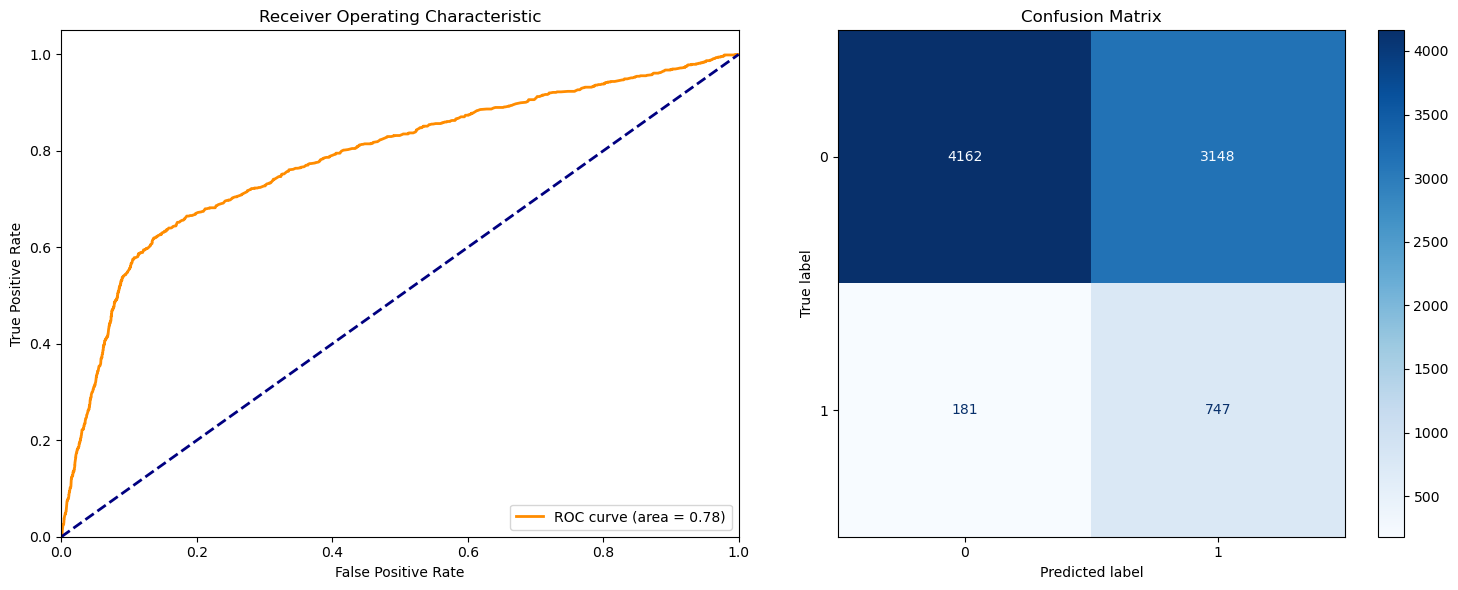

In [292]:
results_catboost_5 = eval_model(y_test, predictions, y_pred_probs)
results_catboost_5

In [297]:
def objective_top_five(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna study to optimize CatBoost classifier.

    Parameters:
      trial (optuna.Trial): An Optuna trial object.

    Returns:
      float: Log loss of the model on test data.
    """
    categorical_columns = X_train[top_five_features].select_dtypes(include=['category', 'object']).columns
    cat_list = categorical_columns.to_list()
    if 'y' in cat_list:
        cat_list.remove('y')
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'task_type': 'GPU',
    }
    smote_space = {'sampling_strategy': trial.suggest_uniform('sampling_strategy', 0.5, 1)}

    X_train_encoded, _ = encode_categorical_columns(X_train[top_five_features], X_test[top_five_features],categorical_columns, 'y')
    smt = SMOTE(random_state=42, **smote_space) 
    x_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)

    
    x_train_smt = reverse_one_hot(x_train_smt, X_train, categorical_columns)
    model = CatBoostClassifier(**param, 
                               loss_function='Logloss', 
                               eval_metric='Logloss', 
                               verbose=0,
                               cat_features=cat_list)
    model.fit(x_train_smt, y_train_smt, early_stopping_rounds=100)
    preds_train = model.predict(X_train[x_train_smt.columns])
    preds_valid = model.predict(X_test[x_train_smt.columns])
    train_f1_mean = f1_score(y_train, preds_train)
    valid_f1_mean = f1_score(y_test, preds_valid)
    
    return calculate_weighted_f1_score(train_f1_mean, valid_f1_mean)

study = optuna.create_study(direction='minimize')

study.optimize(objective_top_five, n_trials=25)  

best_params_5 = study.best_params
print(f"Best parameters: {best_params_5}")

[I 2023-11-13 20:08:00,809] A new study created in memory with name: no-name-0f30ec35-03b7-4be2-a23b-cc3b01a65306
[I 2023-11-13 20:09:30,246] Trial 0 finished with value: 3.1574783869868117 and parameters: {'iterations': 927, 'depth': 8, 'scale_pos_weight': 10, 'learning_rate': 0.0204436615913089, 'random_strength': 75, 'bagging_temperature': 0.4252934267120111, 'od_type': 'Iter', 'l2_leaf_reg': 0.010861517374227858, 'sampling_strategy': 0.9941006471418092}. Best is trial 0 with value: 3.1574783869868117.
[I 2023-11-13 20:11:17,783] Trial 1 finished with value: 2.684261716717444 and parameters: {'iterations': 568, 'depth': 7, 'scale_pos_weight': 4, 'learning_rate': 0.27514995634202266, 'random_strength': 52, 'bagging_temperature': 0.9439774389480167, 'od_type': 'Iter', 'l2_leaf_reg': 1.127182427345022e-08, 'sampling_strategy': 0.5115872676705302}. Best is trial 1 with value: 2.684261716717444.
[I 2023-11-13 20:11:59,574] Trial 2 finished with value: 3.0848468433007765 and parameters: {

Best parameters: {'iterations': 360, 'depth': 8, 'scale_pos_weight': 2, 'learning_rate': 0.29380668404341653, 'random_strength': 29, 'bagging_temperature': 0.6282438938748776, 'od_type': 'Iter', 'l2_leaf_reg': 1.4380801971863924e-08, 'sampling_strategy': 0.5117196753931231}


In [298]:
with open('hyperparams/best_params_5.json', 'w') as json_file:
    json.dump(best_params_5, json_file)
best_params_5

{'iterations': 360,
 'depth': 8,
 'scale_pos_weight': 2,
 'learning_rate': 0.29380668404341653,
 'random_strength': 29,
 'bagging_temperature': 0.6282438938748776,
 'od_type': 'Iter',
 'l2_leaf_reg': 1.4380801971863924e-08,
 'sampling_strategy': 0.5117196753931231}

In [390]:
catboost_params = best_params_5.copy()
catboost_params.pop('sampling_strategy', None)
smote_space = {}
smote_space['sampling_strategy'] = best_params['sampling_strategy']

predictions, y_pred_probs, catboost_5 = full_catboost_train(X_train[top_five_features], y_train, X_test[top_five_features],X_train[top_five_features].select_dtypes(include=['category', 'object']).columns, catboost_params, smote_space)

{'AUC': 0.7247284659653757,
 'F1': 0.4152191894127378,
 'Precision': 0.33691275167785234,
 'Recall': 0.540948275862069,
 'AUC Precision Recall': 0.34974424628226297,
 'Accuracy': 0.8283563971837825}

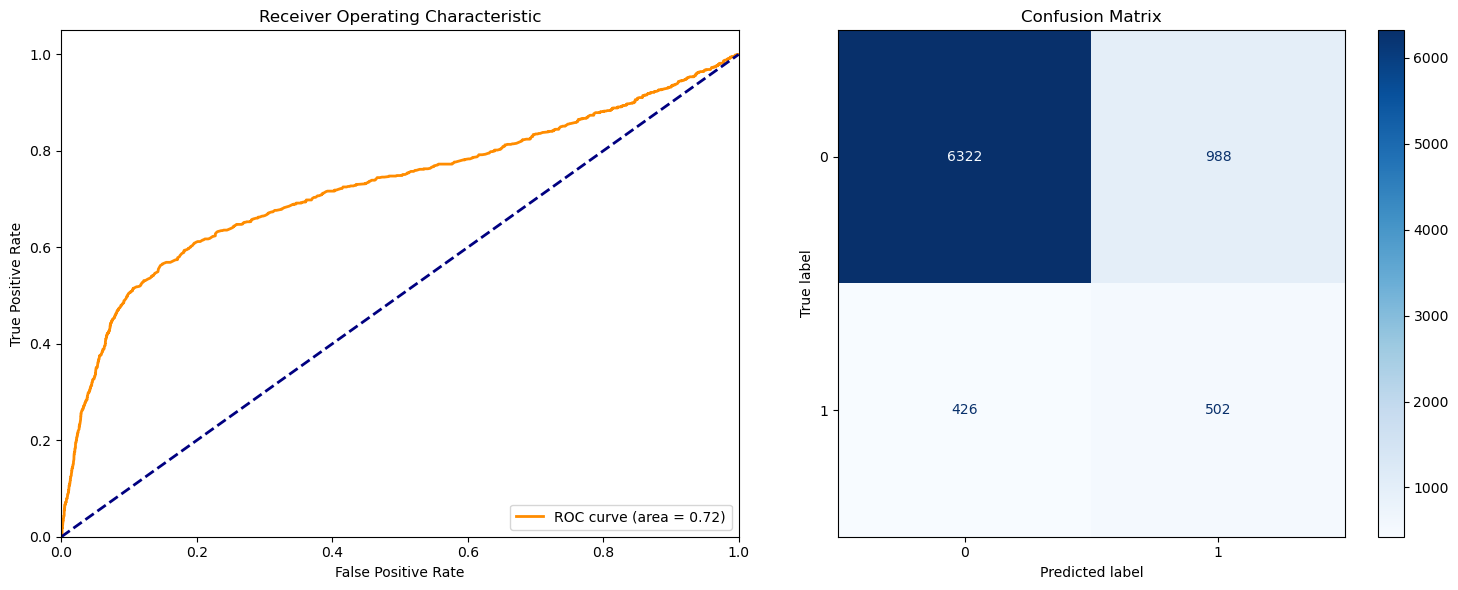

In [385]:
results_catboost_5_tuned = eval_model(y_test, predictions, y_pred_probs)
results_catboost_5_tuned

Final model was optimised in exactly the same measure to produce the plots and results from above, the loss of many of the feautures has severly damaged preformance however this is given the hyperparameter optimisation we have the best model for the given features. The models have been compared in full within the power point presentation. The most important metric to look at here though is the F1 score where we see the five feature as with all the metrics preforms signifiaantly worse than the full model. The reason I choose F1 is that is gives a balance betweeen the precision and recall and it is the metric by which much of the optimisation was done for hyperparameters.

In [392]:
with open('models/catboost_5.pkl', 'wb') as file:
        pickle.dump(catboost_5, file)